In [1]:
# ancestor_id - Identifies sets of notebooks that have a common origin or "ancestor". As no notebook in the 
# test set has an ancestor in the training set, you may find this field to be of use as a grouping factor when 
# constructing validation splits.

# parent_id - Indicates that some version of the notebook id was forked from some version of the notebook parent_id. 
# The notebook parent_id may or may not be present in the training data. (The parent may be missing because someone 
# had forked a private notebook of their own, for instance.

In [2]:
%load_ext autoreload
%autoreload 2

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import math
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tqdm.auto import tqdm

import os
from pathlib import Path
import yaml

import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/ML Projects/Google AI4Code/modules')
import pipeline

print('Libraries Imported')

Mounted at /content/drive
Libraries Imported


In [4]:
# Unzip files from drive to disk
data_path = '/content/drive/MyDrive/Colab Notebooks/ML Projects/Google AI4Code/data/AI4Code.zip'
disk_path = '/content'
check_path = '/content/train'

pipeline.unzip_files(data_path, disk_path, check_path)

Unzipping files:   0%|          | 0/139263 [00:00<?, ?it/s]


 Done unzipping data to disk path.


In [5]:
# Load orders and ancestors in
data_dir = Path(disk_path)
df_orders = pd.read_csv(data_dir / 'train_orders.csv',
                        index_col='id',
                        squeeze=True).str.split()

df_ancestors = pd.read_csv(data_dir / 'train_ancestors.csv', index_col='id')
print('Ancestors and order dataframes loaded in.')

Ancestors and order dataframes loaded in.


### Ancestors IDs

In [6]:
# Check IDs with and without ancestors
non_unique_mask = df_ancestors['ancestor_id'].duplicated(keep=False)

has_ancestors = df_ancestors[non_unique_mask]
no_ancestors = df_ancestors[~non_unique_mask]

print(f"Ids with ancenstors: {len(has_ancestors)}")
print(f"IDs with no ancestors: {len(no_ancestors)}")

Ids with ancenstors: 20727
IDs with no ancestors: 118529


In [7]:
# Using has_ancestors let's collect them
# ancestory_collection will look like so {ancestor_id: [doc_id, doc_id], ...,}

ancestor_collection = {}

for id, ancestor_id  in has_ancestors['ancestor_id'].items():
  if ancestor_id in ancestor_collection:
    ancestor_collection[ancestor_id].append(id)
  else:
    ancestor_collection.setdefault(ancestor_id, [id])

In [8]:
# Collect common ancestors {ancestor_id: [id, id, ...], ancestor_id: ..., }
ancestor_count = {}

for ancestor_id in ancestor_collection:
  ancestor_count[ancestor_id] = len(ancestor_collection[ancestor_id])

sorted_count = sorted(ancestor_count.items(), key=lambda x: x[1], reverse=True)

In [9]:
# Most Common Ancestor ID
print(sorted_count[:5])
print(f'\nThe most common ancestor is ID {sorted_count[0][0]} with {sorted_count[0][1]} ancestors.')

[('4569bfc1', 65), ('51dd4f97', 49), ('021526f8', 44), ('09489e94', 43), ('533ea2ba', 41)]

The most common ancestor is ID 4569bfc1 with 65 ancestors.


Mean at 3.03 and median at 2.0


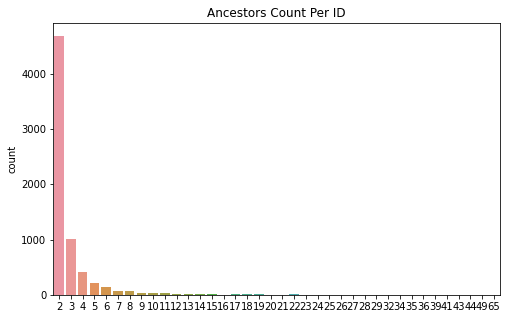

In [10]:
# Let's take a distribution
all_counts = np.asarray(sorted_count)[:, 1].astype('int32')

fig, ax = plt.subplots(figsize=(8,5))
ax = sns.countplot(x=all_counts, ax=ax)
_ = ax.set(title="Ancestors Count Per ID")
print(f"Mean at {all_counts.mean():.2f} and median at {np.median(all_counts)}")

In [11]:
def read_notebook(path):
    return (pd.read_json(path, dtype={'cell_type': 'category', 'source': 'str'})
              .assign(id=path.stem)
              .rename_axis('cell_id'))

disk_train_path = '/content/train/'
shared_ancestor_filepaths = [Path(f'/content/train/{id}.json') for id in ancestor_collection['4569bfc1']]  # ancestor_collection['4569bfc1'] has 65 ancestors
shared_ancestors = [read_notebook(path) for path in shared_ancestor_filepaths]

ancestor_4569bfc1_df = (pd.concat(shared_ancestors)
                        .set_index('id', append=True)
                        .swaplevel()
                        .sort_index(level='id', sort_remaining=False))

In [12]:
ancestor_4569bfc1_df.loc['387384af76fa25']

,cell_type,source
cell_id,,
c457f8c8,code,# Code you have previously used to load data\n...
fe745c1a,code,"# To improve accuracy, create a new Random For..."
f48849c5,code,# path to file you will use for predictions\nt...
322c6fa9,code,# Check your answer\nstep_1.check()\n# step_1....
bbd85ffe,markdown,**[Introduction to Machine Learning Home Page]...
c4dac788,markdown,# Introduction\nMachine learning competitions ...
5a936051,markdown,"# Make Predictions\nRead the file of ""test"" da..."
fe8f56cd,markdown,"Before submitting, run a check to make sure yo..."
ab5293ec,markdown,# Creating a Model For the Competition\n\nBuil...


In [13]:
ancestor_4569bfc1_df.loc['ffa00bb87d8664']

,cell_type,source
cell_id,,
2edc1a8c,code,# Code you have previously used to load data\n...
3e77e12b,code,"# To improve accuracy, create a new Random For..."
46d3e956,code,# path to file you will use for predictions\nt...
56418768,markdown,"# Make Predictions\nRead the file of ""test"" da..."
eff9ccc6,markdown,# Creating a Model For the Competition\n\nBuil...
a3cb0459,markdown,---\n**[Machine Learning Course Home Page](htt...
31e2bb6c,markdown,## Recap\nHere's the code you've written so fa...
953a4001,markdown,**[Machine Learning Course Home Page](https://...
b01580c4,markdown,# Introduction\nMachine learning competitions ...


In [14]:
ancestor_4569bfc1_df.loc['291096231acc58']

,cell_type,source
cell_id,,
a31e4a1d,code,# Code you have previously used to load data\n...
81cc2659,code,"# To improve accuracy, create a new Random For..."
ea2ab160,code,# path to file you will use for predictions\n\...
0d6dfba1,code,# Check your answer\n# step_1.check()\nstep_1....
485ad89f,markdown,## Recap\nHere's the code you've written so fa...
ef25ed0e,markdown,"# Make Predictions\nRead the file of ""test"" da..."
7ea4de9b,markdown,"# Test Your Work\n\nTo test your results, you'..."
25656ae4,markdown,"# Introduction\n\nIn this exercise, you will c..."
72f03428,markdown,---\n\n\n\n\n*Have questions or comments? Visi...


In [15]:
# Ok if two or more cells are similar we drop or have a high similarity we will drop them
# Consider making the source text shorter and truncating it to fist 100 words / chars

def filter_similar_cells(ancestor_collection, similarity_perc=0.85, compare_type='markdown'):
  """Filters out shared ancestor documents that look the same.

  If the document has more than 30% similar cells of the corresponding compare_type,
  both documents get flagged as they have a high chance to be duplicate documents with little
  changes.

  In addition, the document text will be preprocessed before comparison.
  """

  similar_docs = []

  for ancestor_id, ids_with_common_ancestor in tqdm(ancestor_collection.items(), desc='Checking Similarities'):
    # Load shared ancestor documents to memory
    shared_ancestor_filepaths = [Path(f'/content/train/{id}.json') for id in ids_with_common_ancestor] 
    shared_ancestors = [read_notebook(path) for path in shared_ancestor_filepaths]
    df = (pd.concat(shared_ancestors)
            .set_index('id', append=True)
            .swaplevel()
            .sort_index(level='id', sort_remaining=False))
    
    # Get currrent threshold for documents
    # df = df[df['cell_type'] == compare_type]
    threshold = math.ceil((len(df)/len(ids_with_common_ancestor)) * similarity_perc)
    
    # Preprocess text and tokenize
    texts = pipeline.preprocess_text(df['source'], df['cell_type'], disable_print=True)

    if len(texts) > (len(set(texts)) + threshold - 1):
      similar_ids = {}
      dupes = {}

      for idx, text in enumerate(texts):  # Collect duplicate texts
        if text not in dupes:
          dupes[text] = df.iloc[idx].name[0]  # The first text or document it sees will be the one perserved in the dataset
        else:
          key = dupes[text] + '-' + df.iloc[idx].name[0] 
          if key in similar_ids:
            similar_ids[key] += 1
          else:
            similar_ids[key] = 0
      
      for pair, freq in similar_ids.items():
        if freq >= threshold:
          similar_docs.append(pair)
  return similar_docs
       
similar_docs = filter_similar_cells(ancestor_collection)
similar_docs =  [pair.split('-') for pair in similar_docs]

Checking Similarities:   0%|          | 0/6843 [00:00<?, ?it/s]

In [16]:
# Keep one by collecting all pairings

def collect_common_pairs(similar_docs):
  common_pairs = {}
  for pairs in similar_docs:
    if pairs[0] in common_pairs:
      common_pairs[pairs[0]].append(pairs[1])
    else:
      common_pairs[pairs[0]] = [pairs[1]]
  return common_pairs

common_pairs = collect_common_pairs(similar_docs)

In [17]:
# At the end we want a list of IDs that already have similar documents in the dataset

ids_with_similar_docs = list({id 
                              for ids in common_pairs.values()
                              for id in ids})

In [32]:
# excluded_ids_path = '/content/drive/MyDrive/Colab Notebooks/ML Projects/Google AI4Code/data/excluded_ids.yaml'

# with open(excluded_ids_path, 'w+') as stream:
#   try:
#     excluded_ids = yaml.safe_load(stream)
#     excluded_ids['similars'] = ids_with_similar_docs
#     yaml.dump(excluded_ids, stream, default_flow_style=False)
#   except yaml.YAMLError as error:
#     print(error)

### Parent IDs

In [20]:
# Check how many parent ids we have

ids_with_parents = df_ancestors[df_ancestors['parent_id'].notnull()]
print(f"{len(ids_with_parents)} ids have parents with {len(ids_with_parents['parent_id'].unique())} being unique parent_ids")

19542 ids have parents with 13630 being unique parent_ids


In [21]:
# From the above defintion of a parent id, some of these parent ids are not in the dataset
# However, we should track which parent ids are in or outside the dataset

existing_parent_ids = []
unique_parent_ids = ids_with_parents['parent_id'].unique()
all_ids = {path.stem: 0 for path in (data_dir / 'train').glob('*.json')}  # Hash mapping for the below operation will be faster

for parent_id in tqdm(unique_parent_ids, desc='Checking for existing parent ids'):
  try:
    all_ids[parent_id]
    existing_parent_ids.append(parent_id)
  except KeyError:
    pass

Checking for existing parent ids:   0%|          | 0/13630 [00:00<?, ?it/s]

In [22]:
# No parent ids exist in the given dataset
print(existing_parent_ids)

[]
